<h1><center><font size="6">Classification of Crochet Stitches</font></center></h1>

In [465]:
# pip install numpy split-folders scikit-image keras scikit-learn matplotlib tensorflow scikeras streamlit==1.11.0 pyngrok

Note: you may need to restart the kernel to use updated packages.


In [437]:
import os
import numpy as np
import random
import tensorflow as tf
import time
import csv
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pickle import dump, load
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras import Input, Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
sns.set_theme(style="whitegrid", palette="muted")
sns.set(font_scale=1.2)

# 1 Prepare dataset

In [3]:
# Get path to dataset in local computer
cwd = os.path.join(os.getcwd(), "Crochet_Stitches_Dataset_100")
cwd

'/Users/stephanieyolanda/Documents/Study/Y3S2/CM3070 Final Project/Implementation (Final)/Crochet_Stitches_Dataset_100'

In [16]:
# Get the labels from the folder names in dataset
classes = []
for file in os.scandir(cwd):
    if not file.name.startswith('.'):
        classes.append(file.name)
classes

['SC', 'DC', 'HDC']

## 1.1 Import images and labels

In [18]:
def import_dataset(ds_pkl_path, dataset_path, classes, img_size=(224,224)):
    """ Return the images and labels of the original dataset
 
    Parameters
    ------------
        ds_pkl_path: str
            The path of the dataset (to be saved or already saved) in pkl format.
        dataset_path: str
            The path of the folder of the dataset.
        classes: list
            The classification labels of the dataset.
        img_size: tuple, optional
            The image size to be set to the dataset images (default is 224 by 224).
    Return
    -----------
        images : list
            The images of the dataset. 
        labels : list
            The labels of the dataset.
    """
    
    if os.path.isfile(ds_pkl_path) == False:

        images, labels = [], []

        for c in classes:
            label = classes.index(c)
            for file in os.scandir(os.path.join(dataset_path, c)):
                if not file.name.startswith('.'):
                    image = load_img(file.path, target_size=img_size)
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(label)

        ds = {'images': images, 
              'labels': labels}
        dump(ds, open(ds_pkl_path, 'wb'))

    else:
        ds = load(open(ds_pkl_path, 'rb'))
        images, labels = ds['images'], ds['labels']
        
    return images, labels

In [19]:
images, labels = import_dataset('original_ds.pkl', cwd, classes)

## 1.2 Display imported images with labels

In [20]:
# Adapted from https://www.tensorflow.org/tutorials/images/data_augmentation

def display_dataset(images, labels):
    """ Display the dataset (images with labels)
 
    Parameters
    ------------
        images: list
            The images of the dataset.
        labels: list
            The labels of the dataset.
    """
    
    plt.figure(figsize=(10,10))

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        index = random.randint(0, len(images)-1)
        plt.imshow(images[index].astype(np.uint8))
        plt.title(labels[index])
        plt.axis('off')

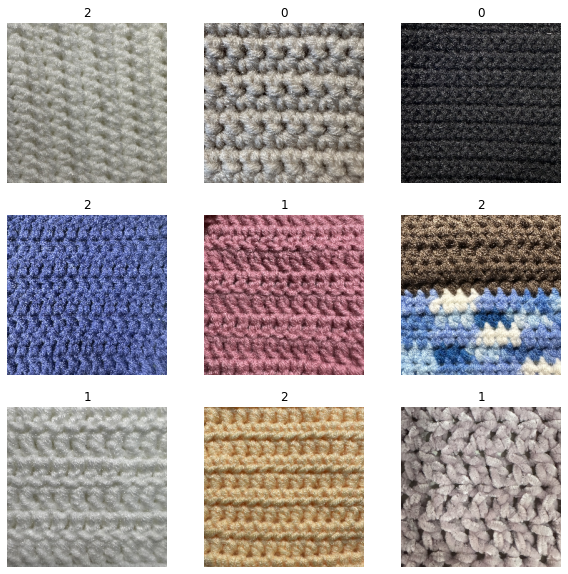

In [21]:
display_dataset(images, labels)

# 2 Pre-process data
## 2.1 Convert to NumPy arrays

In [23]:
def data_to_numpy(images, labels):
    """ Convert the dataset lists into NumPy arrays
 
    Parameters
    ------------
        images: list
            The images of the dataset.
        labels: list
            The labels of the dataset.
    Return
    -----------
        X : numpy.ndarray
            The images of the dataset. 
        y : numpy.ndarray
            The labels of the dataset.
    """
    
    # Convert data to numpy array
    X = np.array(images)
    y = np.array(labels)
    return X, y

In [24]:
# Convert images and labels to NumPy arrays
X, y = data_to_numpy(images, labels)

## 2.2 Convert to grayscale

In [25]:
def X_to_grayscale(X):
    """ Convert the images to grayscale
 
    Parameters
    ------------
        X : numpy.ndarray
            The images of the dataset.
    Return
    -----------
        X_gs : numpy.ndarray
            The images of the dataset converted to grayscale.
    """
    
    # Convert images to grayscale
    X_gs = rgb2gray(np.copy(X))

    # Reshape image from grayscale colorspace to rgb colorspace
    X_gs = np.expand_dims(X_gs, axis=3)
    X_gs = X_gs.repeat(3, axis=-1)
    return X_gs

In [26]:
# Convert images to grayscale
X_gs = X_to_grayscale(X)

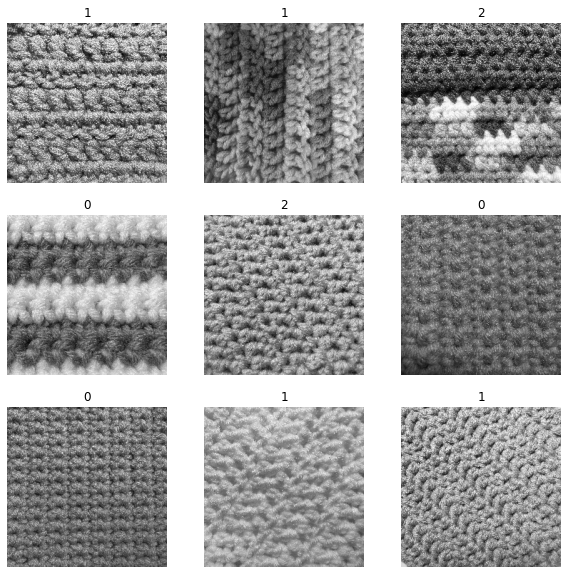

In [27]:
# Display grayscale images
display_dataset(X_gs, labels)

## 2.3 Pre-process data (label vectorization and data normalization)

In [28]:
def preprocess_data(X, y):   
    """ Preprocess the dataset according to the models' preprocessing requirements
 
    Parameters
    ------------
        X : numpy.ndarray
            The images of the dataset.
        y : numpy.ndarray
            The labels of the dataset.
    Return
    -----------
        X_baseline : numpy.ndarray
            The preprocessed images of the dataset ([0,1] representation).
        X_xception : numpy.ndarray
            The preprocessed images of the dataset according to Xception.
        X_vgg16 : numpy.ndarray
            The preprocessed images of the dataset according to VGG-16.
        X_baseline : numpy.ndarray
            The preprocessed images of the dataset according to ResNet-50.
        y_vect : numpy.ndarray
            The vectorized (one hot encoding) labels of the dataset.
    """

    # Label vectorization
    y_vect = to_categorical(np.copy(y))

    # Data normalization
    print('Data normalization:\n')
    
    X_baseline = np.copy(X)/255
    print('Baseline', X_baseline[0][0][0])
    X_xception = xception_preprocess(np.copy(X))
    print('Xception', X_xception[0][0][0])
    X_vgg16 = vgg16_preprocess(np.copy(X))
    print('VGG16   ', X_vgg16[0][0][0])
    X_resnet50 = resnet50_preprocess(np.copy(X))
    print('ResNet50', X_resnet50[0][0][0])

    return X_baseline, X_xception, X_vgg16, X_resnet50, y_vect

In [29]:
# Pre-process dataset for color images
X_baseline, X_xception, X_vgg16, X_resnet50, y = preprocess_data(X, y)

Data normalization:

Baseline [0.5058824  0.5058824  0.45882353]
Xception [ 0.01176476  0.01176476 -0.08235294]
VGG16    [13.060997  12.221001   5.3199997]
ResNet50 [13.060997  12.221001   5.3199997]


In [30]:
# Pre-process dataset for grayscale images
X_baseline_gs, X_xception_gs, X_vgg16_gs, X_resnet50_gs, _ = preprocess_data(X_gs, y)

Data normalization:

Baseline [0.5024894 0.5024894 0.5024894]
Xception [0.00497878 0.00497878 0.00497878]
VGG16    [24.195793 11.355797  4.454796]
ResNet50 [24.195793 11.355797  4.454796]


## 2.4 Split dataset

In [31]:
def split_dataset(X, y):
    """ Split the dataset to train, test, and validation sets
 
    Parameters
    ------------
        X : numpy.ndarray
            The images of the dataset.
        y : numpy.ndarray
            The labels of the dataset.
            
    Return
    -----------
        dataset : dict
            The train, test, and validation sets of the dataset
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=1, 
                                                        stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.4, 
                                                      shuffle=True, 
                                                      random_state=1, 
                                                      stratify=y_train)
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    print('X_val  :', X_val.shape)
    print('y_val  :', y_val.shape)
    print('X_test :', X_test.shape)
    print('y_test :', y_test.shape)
    
    dataset = {'X_train' : X_train,
               'X_test': X_test,
               'X_val': X_val,
               'y_train': y_train,
               'y_test': y_test,
               'y_val': y_val}
    
    return dataset

#### Split all versions of the dataset

In [350]:
# Color version
print('Baseline:')
ds_baseline = split_dataset(X_baseline, y)
print('\nXception:')
ds_xception = split_dataset(X_xception, y)
print('\nVGG16:')
ds_vgg16 = split_dataset(X_vgg16, y)
print('\nResNet50:')
ds_resnet50 = split_dataset(X_resnet50, y)

# Grayscale version
print('\nBaseline (Grayscale):')
ds_baseline_gs = split_dataset(X_baseline_gs, y)
print('\nXception (Grayscale):')
ds_xception_gs = split_dataset(X_xception_gs, y)
print('\nVGG16 (Grayscale):')
ds_vgg16_gs = split_dataset(X_vgg16_gs, y)
print('\nResNet50 (Grayscale):')
ds_resnet50_gs = split_dataset(X_resnet50_gs, y)

Baseline:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Xception:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

VGG16:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

ResNet50:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Baseline (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Xception (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

VGG16 (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)


#### Plot data

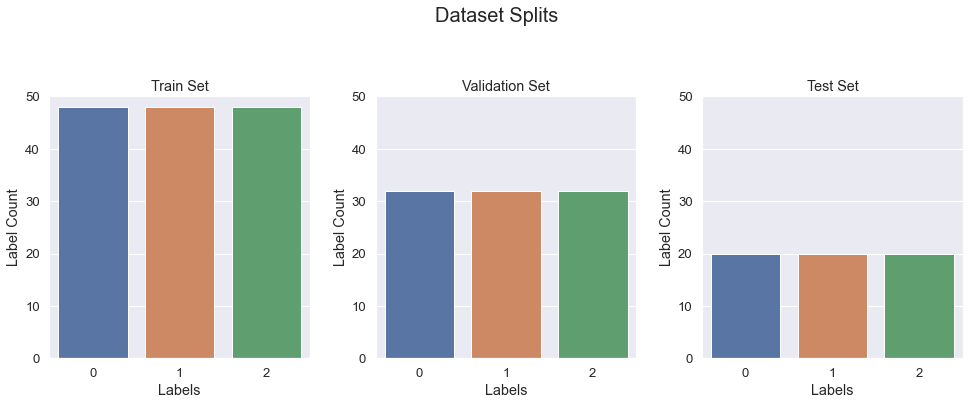

In [349]:
fig, ax = plt.subplots(1,3, figsize=(14,6))
fig.tight_layout(pad=2, rect=[0, 0.05, 1, 0.85])
fig.suptitle('Dataset Splits', fontsize=20)
# fig, ax = plt.subplots()
for idx, group in enumerate([('Train', np.argmax(ds_baseline['y_train'],axis=1)), 
                             ('Validation', np.argmax(ds_baseline['y_val'], axis=1)), 
                             ('Test', np.argmax(ds_baseline['y_test'], axis=1))]):
    data = group[1]
    sns.countplot(ax=ax[idx],x=data)
    ax[idx].set_ylim(0, 50)
    ax[idx].set_title(f'{group[0]} Set')
    ax[idx].set_xlabel(f'Labels')
    ax[idx].set_ylabel('Label Count')
    
plt.savefig('Appendix/train_test_val_freq.png')
plt.show()

# 3 Data augmentation

In [33]:
train_gen = ImageDataGenerator(zoom_range=[0.6,1.2],
                               rotation_range=40,
                               shear_range=10,
                               brightness_range=[0.5, 1.1],
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

## 3.1 Online data augmentation

In [34]:
def online_data_augmentation(dataset, batch_size, train_gen=train_gen):
    """ Online data augmentation on dataset
 
    Parameters
    ------------
        dataset : numpy.ndarray
            The dataset to be augmented.
        batch_size : numpy.ndarray
            The number of data per cycle.
        train_gen : keras.preprocessing.image.ImageDataGenerator, optional
            The transformations for data augmentation.
            
    Return
    -----------
        train_aug : keras.preprocessing.image.NumpyArrayIterator
            The train, test, and validation sets of the dataset.
    """

    train_aug = train_gen.flow(dataset['X_train'], dataset['y_train'], batch_size=batch_size)

    return train_aug

## 3.2 Offline data augmentation

#### Split unprocessed data

In [257]:
split_ds = split_dataset(X, y)
X_train, y_train = split_ds['X_train'], split_ds['y_train']

X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)


#### Check number of train data for each class

In [258]:
SC, DC, HDC = 0, 0, 0

# Loop through train data labels
for i in range(len(y_train)):
    # Get class of current label
    c = str(classes[np.argmax(y_train[i])])
    # Add 1 to label variable if current label match
    if c == 'SC':
        SC += 1
    elif c == 'DC':
        DC += 1
    elif c == 'HDC':
        HDC += 1

# Print results
print('Number of images in each class:\n')
print('SC:', SC)
print('DC:', DC)
print('HDC:', HDC)

Number of images in each class:

SC: 48
DC: 48
HDC: 48


#### Implement augmentation

In [305]:
def offline_data_augmentation(X, y, classes, folder_name='Train_Aug_Dataset'):
    """ Offline data augmentation on dataset
 
    Parameters
    ------------
        X : numpy.ndarray
            The images of the dataset.
        y : numpy.ndarray
            The labels of the dataset.
        classes : list
            The classification labels of the dataset.
        folder_name : 
            The folder name the images are saved into.
    """
    
    for i in range(len(X)):
        c = str(classes[np.argmax(y[i])])
        aug_path = os.path.join(folder_name, c)

        j = 0
        for batch in train_gen.flow(np.expand_dims(X[i], axis=0), 
                                    batch_size=1, 
                                    save_to_dir=aug_path, 
                                    save_prefix=str(c), 
                                    save_format='jpeg'):
            j += 1
            print(j)
            if j>5:
                break

In [306]:
# Export augmented images into local disk (comment out when done)
# offline_data_augmentation(X_train, y_train, classes)

In [307]:
# Import augmented dataset from local disk (images are deleted manually to ensure a balanced dataset)
images_aug, labels_aug = import_dataset('train_aug_dataset.pkl', os.path.join(os.getcwd(), 'Train_Aug_Dataset'), classes)

# Print number of augmented images
print('Number of images in each class:')
print('0:',labels_aug.count(0))
print('1:',labels_aug.count(1))
print('2:',labels_aug.count(2))

# Convert images and labels to NumPy arrays
X_train_aug, y_train_aug = data_to_numpy(images_aug, labels_aug)

# Shuffle dataset
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=0)

Number of images in each class:
0: 280
1: 280
2: 280


#### Pre-process augmented data

In [308]:
# Original (Color)
print('Original color dataset')
print('----------------------')
X_train_baseline_aug, X_train_xception_aug, X_train_vgg16_aug, X_train_resnet50_aug, y_train_aug = preprocess_data(X_train_aug, y_train_aug)

# Grayscale
print('\nGrayscale dataset')
print('-------------------')
X_train_gs_aug = X_to_grayscale(X_train_aug) # Convert images to grayscale
X_train_baseline_gs_aug, X_train_xception_gs_aug, X_train_vgg16_gs_aug, X_train_resnet50_gs_aug, _ = preprocess_data(X_train_gs_aug, y_train_aug)

Original color dataset
----------------------
Data normalization:

Baseline [0.47843137 0.48235294 0.4627451 ]
Xception [-0.04313725 -0.03529412 -0.0745098 ]
VGG16    [14.060997   6.2210007 -1.6800003]
ResNet50 [14.060997   6.2210007 -1.6800003]

Grayscale dataset
-------------------
Data normalization:

Baseline [0.48010585 0.48010585 0.48010585]
Xception [-0.03978831 -0.03978831 -0.03978831]
VGG16    [18.487991  5.647995 -1.253006]
ResNet50 [18.487991  5.647995 -1.253006]


#### Combine augmented train set with unaugmented train set

In [309]:
# Original (Color)
X_train_baseline_cmb = np.concatenate((np.copy(X_train_baseline_aug), np.copy(ds_baseline['X_train'])))
X_train_xception_cmb = np.concatenate((np.copy(X_train_xception_aug), np.copy(ds_xception['X_train'])))
X_train_vgg16_cmb = np.concatenate((np.copy(X_train_vgg16_aug), np.copy(ds_vgg16['X_train'])))
X_train_resnet50_cmb = np.concatenate((np.copy(X_train_resnet50_aug), np.copy(ds_resnet50['X_train'])))

# Grayscale
X_train_baseline_gs_cmb = np.concatenate((np.copy(X_train_baseline_gs_aug), np.copy(ds_baseline_gs['X_train'])))
X_train_xception_gs_cmb = np.concatenate((np.copy(X_train_xception_gs_aug), np.copy(ds_xception_gs['X_train'])))
X_train_vgg16_gs_cmb = np.concatenate((np.copy(X_train_vgg16_gs_aug), np.copy(ds_vgg16_gs['X_train'])))
X_train_resnet50_gs_cmb = np.concatenate((np.copy(X_train_resnet50_gs_aug), np.copy(ds_resnet50_gs['X_train'])))

In [310]:
# Combine label data
y_train_cmb = np.concatenate((np.copy(y_train_aug), np.copy(ds_baseline['y_train'])))

In [311]:
# Print total number of training data after augmentation
print('Total number of training data:', len(y_train_cmb))

Total number of training data: 984


#### Copy dictionary format of other datasets (storing all sets and labels)

In [312]:
# Original (Color)
ds_baseline_aug = ds_baseline.copy()
ds_xception_aug = ds_xception.copy()
ds_vgg16_aug = ds_vgg16.copy()
ds_resnet50_aug = ds_resnet50.copy()

# Grayscale
ds_baseline_gs_aug = ds_baseline_gs.copy()
ds_xception_gs_aug = ds_xception_gs.copy()
ds_vgg16_gs_aug = ds_vgg16_gs.copy()
ds_resnet50_gs_aug = ds_resnet50_gs.copy()

#### Update X_train and y_train with augmented data

In [343]:
# Original (Color)
ds_baseline_aug['X_train'], ds_baseline_aug['y_train'] = shuffle(X_train_baseline_cmb, y_train_cmb, random_state=0)
ds_xception_aug['X_train'], ds_xception_aug['y_train'] = shuffle(X_train_xception_cmb, y_train_cmb, random_state=0)
ds_vgg16_aug['X_train'], ds_vgg16_aug['y_train'] = shuffle(X_train_vgg16_cmb, y_train_cmb, random_state=0)
ds_resnet50_aug['X_train'], ds_resnet50_aug['y_train'] = shuffle(X_train_resnet50_cmb, y_train_cmb, random_state=0)

# Grayscale
ds_baseline_gs_aug['X_train'], ds_baseline_gs_aug['y_train'] = shuffle(X_train_baseline_gs_cmb, y_train_cmb, random_state=0)
ds_xception_gs_aug['X_train'], ds_xception_gs_aug['y_train'] = shuffle(X_train_xception_gs_cmb, y_train_cmb, random_state=0)
ds_vgg16_gs_aug['X_train'], ds_vgg16_gs_aug['y_train'] = shuffle(X_train_vgg16_gs_cmb, y_train_cmb, random_state=0)
ds_resnet50_gs_aug['X_train'], ds_resnet50_gs_aug['y_train'] = shuffle(X_train_resnet50_gs_cmb, y_train_cmb, random_state=0)

# 4 Define required functions

## 4.1 Initialize variables (hyperparameters)

In [36]:
INPUT_DIMENSION = ds_baseline['X_train'].shape[1:4]
OUTPUT_DIMENSION = ds_baseline['y_train'].shape[1]
LEARNING_RATE = 0.001
# OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
OPTIMIZER = 'Adam'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = [CategoricalAccuracy(name='accuracy'), 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]
FIRST_DROPOUT = True
LAYERS = {"dense_params": [],
          "add_dropout": []} # True or False
DROPOUT_RATE = 0.5
BATCH_SIZE = 16
EPOCHS = 20
MONITOR = 'val_loss'
PATIENCE = 5
EARLY_STOP = EarlyStopping(monitor=MONITOR, 
                           restore_best_weights=True, 
                           patience=PATIENCE, 
                           verbose=1)
DS_OPT = {"grayscale":False,
          "aug_type":'None'}

## 4.2 Function for choosing dataset

In [37]:
def choose_dataset(model_name, grayscale, aug_type, batch_size=BATCH_SIZE):
    """ Return the dataset based on the variables
 
    Parameters
    ------------
        model_name : str
            The model name ('baseline_model', 'xception_model', 'vgg16_model', or 'resnet50_model')
        grayscale : bool
            Whether the dataset is grayscale or not.
        aug_type : str
            The augmentation type ('None', 'Online', or 'Offline').
        batch_size : int, optional
            The batch size for online data augmentation.
    Return
    -----------
        dataset : dict
            The chosen dataset.
        dataset_str : str
            The information of the chosen dataset.
    """
    
    key = ''
    if model_name == 'baseline_model':
        key = 'Baseline'
    elif model_name == 'xception_model':
        key = 'Xception'
    elif model_name == 'vgg16_model':
        key = 'VGG16'
    elif model_name == 'resnet50_model':
        key = 'ResNet50'
    
    if grayscale == False:
        
        if aug_type == 'None':
            
            # Original dataset
            if os.path.isfile('datasets/og_ds.pkl') == False:  
                og_ds = {'Baseline':ds_baseline,
                            'Xception':ds_xception,
                            'VGG16':ds_vgg16,
                            'ResNet50':ds_resnet50}
                dump(og_ds, open('datasets/og_ds.pkl', 'wb'))
            else:
                og_ds = load(open('datasets/og_ds.pkl', 'rb'))
                
            dataset = og_ds[key]
            dataset_str = 'og_ds' + '/' + key
            
        elif aug_type == 'Online':
            
            # Original dataset
            if os.path.isfile('datasets/og_ds.pkl') == False:  
                og_ds = {'Baseline':ds_baseline,
                            'Xception':ds_xception,
                            'VGG16':ds_vgg16,
                            'ResNet50':ds_resnet50}
                dump(og_ds, open('datasets/og_ds.pkl', 'wb'))
            else:
                og_ds = load(open('datasets/og_ds.pkl', 'rb'))
                
            # Online augmented dataset
            on_aug_ds = {'Baseline':online_data_augmentation(ds_baseline, batch_size),
                         'Xception':online_data_augmentation(ds_xception, batch_size),
                         'VGG16':online_data_augmentation(ds_vgg16, batch_size),
                         'ResNet50':online_data_augmentation(ds_resnet50, batch_size)}
            
            dataset = [on_aug_ds[key],og_ds[key]]
            dataset_str = 'on_aug_ds' + '/' + key
            
        elif aug_type == 'Offline':
            
            dataset = off_aug_ds[key]
            dataset_str = 'off_aug_ds' + '/' + key
            
    elif grayscale == True:
        
        if aug_type == 'None':
            
            # Original grayscale dataset
            if os.path.isfile('datasets/og_gs_ds.pkl') == False:  
                og_gs_ds = {'Baseline':ds_baseline_gs,
                            'Xception':ds_xception_gs,
                            'VGG16':ds_vgg16_gs,
                            'ResNet50':ds_resnet50_gs}
                dump(og_gs_ds, open('datasets/og_gs_ds.pkl', 'wb'))
            else:
                og_gs_ds = load(open('datasets/og_gs_ds.pkl', 'rb'))
                
            dataset = og_gs_ds[key]
            dataset_str = 'og_gs_ds' + '/' + key
            
        elif aug_type == 'Online':
            
             # Original grayscale dataset
            if os.path.isfile('datasets/og_gs_ds.pkl') == False:  
                og_gs_ds = {'Baseline':ds_baseline_gs,
                            'Xception':ds_xception_gs,
                            'VGG16':ds_vgg16_gs,
                            'ResNet50':ds_resnet50_gs}
                dump(og_gs_ds, open('datasets/og_gs_ds.pkl', 'wb'))
            else:
                og_gs_ds = load(open('datasets/og_gs_ds.pkl', 'rb'))
                
            # Online augmented grayscale dataset
            on_aug_gs_ds = {'Baseline':online_data_augmentation(ds_baseline_gs, batch_size),
                            'Xception':online_data_augmentation(ds_xception_gs, batch_size),
                            'VGG16':online_data_augmentation(ds_vgg16_gs, batch_size),
                            'ResNet50':online_data_augmentation(ds_resnet50, batch_size)}
            
            dataset = [on_aug_gs_ds[key],og_gs_ds[key]]
            dataset_str = 'on_aug_gs_ds' + '/' + key
            
        elif aug_type == 'Offline':
            
            # Offline augmented grayscale dataset
            if os.path.isfile('datasets/off_aug_gs_ds.pkl') == False:  
                off_aug_gs_ds = {'Baseline':ds_baseline_gs_aug,
                                 'Xception':ds_xception_gs_aug,
                                 'VGG16':ds_vgg16_gs_aug,
                                 'ResNet50':ds_resnet50_gs_aug}
                dump(off_aug_gs_ds, open('datasets/off_aug_gs_ds.pkl', 'wb'))
            else:
                off_aug_gs_ds = load(open('datasets/off_aug_gs_ds.pkl', 'rb'))
                
            dataset = off_aug_gs_ds[key]
            dataset_str = 'off_aug_gs_ds' + '/' + key
            
    return dataset, dataset_str

## 4.3 Functions for documentation purposes

In [38]:
def get_model_params(dataset_str, grayscale, aug_type,
                     layers=LAYERS,
                     dropout_rate=DROPOUT_RATE,
                     first_dropout=FIRST_DROPOUT,
                     input_dimension=INPUT_DIMENSION,
                     output_dimension=OUTPUT_DIMENSION,
                     optimizer=OPTIMIZER,
                     loss_function=LOSS_FUNC,
                     learning_rate=LEARNING_RATE,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS): 
    """ Return the hyperparameters
 
    Parameters
    ------------
        dataset_str : str
            The information of the chosen dataset.
        grayscale : bool
            Whether the dataset is grayscale or not.
        aug_type : str
            The augmentation type ('None', 'Online', or 'Offline').
        layers : dict
            The dense layers and the following dropout layer
        dropout_rate : float, optional
            The rate of the dropout layers.
        first_dropout : bool, optional
            Whether dropout layer is added before dense layers.
        input_dimension : tuple, optional
            The input dimension of the model.
        output_dimension : int, optional
            The output dimension of the model.
        optimizer : int or keras.optimizers, optional
            The optimizer of the model.
        loss_function : str, optional
            The loss function of the model.
        learning_rate : float, optional
            The learning rate of the optimizer.
        batch_size : int, optional
            The batch size of the model.
        epochs : int, optional
            The number of epochs for the training process.
        
    Return
    -----------
        model_params : dict
            The hyperparameters of the model.
    """
    
    model_params = {'Dataset':str(dataset_str),
                    'Augmentation':str(aug_type),
                    'Grayscale':bool(grayscale),
                    'Dense_Params':str(layers['dense_params']),
                    'Add_Dropout':bool(layers['add_dropout']),
                    'Dropout_Rate':float(dropout_rate),
                    'First_Dropout':bool(first_dropout),
                    'Input_Dimension':str(input_dimension), 
                    'Output_Dimension':int(output_dimension),
                    'Optimizer':str(optimizer),
                    'Loss_Function':str(loss_function),
                    'Learning_Rate':float(learning_rate),
                    'Batch_Size':int(batch_size),
                    'Epochs':int(epochs)}

    
    return model_params

In [41]:
# Adapted from https://saturncloud.io/blog/how-to-use-pandas-to-check-if-a-row-exists-with-certain-values/

def check_model_exist(model_name, model_params, model_params_path='model_params.csv'):
    """ Check if models with certain hyperparameters already exist
 
    Parameters
    ------------
        model_name : str
            The model name ('baseline_model'/xception_model'/'vgg16_model'/'resnet50_model').
        model_params : dict
            The hyperparameters of the model.
        model_params_path : str, optional
            The path of the csv file of model hyperparameters in local disk (default is 'model_params.csv').
            
    Return
    -----------
        model_exist : bool
            Whether model with certain hyperparmeters exist already.
        paths : dict
            Paths of model and model history in local disk.
    """
    
    model_exist = False
    paths = None
    
    if os.path.isfile(model_params_path):
        
        # Import csv as dataframe
        df = pd.read_csv(model_params_path)
        
        # Filter out dataframe for models with same hyperparameters
        df_exist = df[(df['Model_Path'].str.contains(str(model_name))) &
                      (df['History_Path'].str.contains(str(model_name))) &
                        (df['Dataset']==str(model_params['Dataset'])) &
                        (df['Dense_Params']==str(model_params['Dense_Params'])) &
                        (df['Add_Dropout']==bool(model_params['Add_Dropout'])) &
                        (df['Dropout_Rate']==float(model_params['Dropout_Rate'])) &
                        (df['First_Dropout']==float(model_params['First_Dropout'])) &
                        (df['Input_Dimension']==str(model_params['Input_Dimension'])) &
                        (df['Output_Dimension']==int(model_params['Output_Dimension'])) &
                        (df['Optimizer']==str(model_params['Optimizer'])) &
                        (df['Loss_Function']==str(model_params['Loss_Function'])) &
                        (df['Learning_Rate']==float(model_params['Learning_Rate'])) &
                        (df['Batch_Size']==int(model_params['Batch_Size'])) &
                        (df['Epochs']==int(model_params['Epochs'])) &
                        (df['Augmentation']==str(model_params['Augmentation'])) &
                        (df['Grayscale']==bool(model_params['Grayscale']))]

        # If model with same hyperparameters already exist
        if not df_exist.empty:
            model_exist = True
            paths = {'Model_Path':df_exist['Model_Path'].values[0],
                     'History_Path':df_exist['History_Path'].values[0]}

    return model_exist, paths

In [42]:
def check_metrics_exist(model_paths, model_metrics_path='model_metrics.csv'):
    """ Check if metric scores of the model have been stored in csv file 
 
    Parameters
    ------------
        model_paths : dict
            Paths of model and model history in local disk.
        model_metrics_path : str, optional
            The path of the csv file of model metrics in local disk (default is 'model_metrics.csv').
            
    Return
    -----------
        metrics_exist : bool
            Whether metric scores of certain model are already stored in csv file.
    """
    
    metrics_exist = False
    
    if os.path.isfile(model_metrics_path):
        
        # Import csv as dataframe
        df = pd.read_csv(model_metrics_path)
        
        # Filter out dataframe for the specific model
        df_exist = df[(df['Model_Path']==str(model_paths['Model_Path'])) &
                      (df['History_Path']==str(model_paths['History_Path']))]

        # If metrics of model exist or have been stored in the csv file
        if not df_exist.empty:
            metrics_exist = True

    return metrics_exist

In [43]:
def get_model_paths(model_name):
    """ Return the paths of model and model history
 
    Parameters
    ------------
        model_name : str
            The model name ('xception_model', 'vgg16_model', 'resnet50_model').
            
    Return
    -----------
        paths : dict
            Paths of model and model history in local disk.
    """
    
    # Use current time as unique id of filename
    timestamp = str(int(time.time()))
    
    # Paths for model and model history
    model_path = "models/"+model_name+"_"+timestamp+".keras"
    history_path = "models/trained_"+model_name+"_"+timestamp+".pkl"
    
    # Store paths as a dictionary
    paths = {'Model_Path':model_path,
             'History_Path':history_path}
    
    return paths

In [39]:
# data can be model_params or metrics
def export_to_csv(paths, data, csv_filename):
    """ Export data to csv
 
    Parameters
    ------------
        paths : dict
            Paths of model and model history in local disk.
        data : dict
            Data to be exported as csv.
        csv_filename : str
            The filename of the csv to be saved as.
    
    """

    # Combine the paths and data as a single dict
    data = paths | data

    # Write to new csv if file not exist
    if not os.path.isfile(csv_filename):
        with open(csv_filename, 'w') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writeheader()
            w.writerow(data)
            f.close()
    # Append to existing csv
    else:
        with open(csv_filename, 'a', newline='') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writerow(data)
            f.close()

## 4.4 Functions for building and training models

In [40]:
def build_pretrained_model(model_name='resnet50_model',
              dropout_rate = DROPOUT_RATE,
              first_dropout = FIRST_DROPOUT,
              layers = LAYERS,
              input_dimension=INPUT_DIMENSION,
              output_dimension=OUTPUT_DIMENSION, 
              optimizer=OPTIMIZER,
              learning_rate=LEARNING_RATE,
              loss_func=LOSS_FUNC, 
              metrics=METRICS):
    
    """ Build model architecture based on pre-trained model
 
    Parameters
    ------------
        model_name : str
            The model name ('xception_model'/'vgg16_model'/'resnet50_model').
        dropout_rate : float, optional
            The rate of the dropout layers.
        first_dropout : bool, optional
            Whether dropout layer is added before dense layers.
        layers : dict
            The dense layers and the following dropout layer
        input_dimension : tuple, optional
            The input dimension of the model.
        output_dimension : int, optional
            The output dimension of the model.
        optimizer : int or keras.optimizers, optional
            The optimizer of the model.
        learning_rate : float, optional
            The learning rate of the optimizer.
        loss_function : str, optional
            The loss function of the model.
        metrics : list, optional
            The metrics used to evaluate the model.
            
    Return
    -----------
        model : keras.engine.functional.Functional
            The complete model built.
    
    """
    
    # Choose pre-trained model
    if (model_name.lower()).find('xception') != -1:
        pretrained_model = Xception(include_top=False,
                                    weights='imagenet',
                                    classes=output_dimension,
                                    input_shape=input_dimension)
    elif (model_name.lower()).find('vgg') != -1:
        pretrained_model = VGG16(include_top=False,
                                 weights='imagenet',
                                 classes=output_dimension,
                                 input_shape=input_dimension
                                )
    else:
        pretrained_model = ResNet50(include_top=False,
                                    weights='imagenet',
                                    classes=output_dimension,
                                    input_shape=input_dimension)

    # Set pre-trained model layers to be not trainable 
    for layer in pretrained_model.layers:
        layer.trainable = False
      
        
    # Build layers on pre-trained model
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)

    # Either add or don't add drop out layer before the dense layers
    if first_dropout == True:
        x = Dropout(dropout_rate)(x)

    # Add dense layers
    if len(layers['dense_params']) != len(layers['add_dropout']):
        print("Error")
        raise SystemExit("Dense params and dropout rates not same length")
    else:
        if len(layers['dense_params']) > 0 and len(layers['add_dropout']) > 0:
            for layer in range(len(layers['dense_params'])):
                x = Dense(layers['dense_params'][layer], activation='relu')(x)
                if layers['add_dropout'][layer] == True:
                    x = Dropout(dropout_rate)(x)
    
    model_outputs = Dense(output_dimension, activation='softmax')(x)
    
    model = Model(pretrained_model.input, model_outputs)

    # Set model name
    model._name = model_name
    
    # Additional conditions for other optimizers can be added in the future
    if optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                      loss=loss_func, 
                      metrics=metrics)
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                      loss=loss_func, 
                      metrics=metrics)
        
    return model

In [44]:
def train_model(model_name, model, model_params, dataset,     
                overwrite=False,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS):
    """ Train model
 
    Parameters
    ------------
        model_name : str
            The model name ('baseline_model'/'xception_model'/'vgg16_model'/'resnet50_model').
        model : keras.engine.functional.Functional
            The complete model built.
        model_params : dict
            The hyperparameters of the model.
        dataset : dict
            The dataset for the model training process.
        overwrite : bool, optional
            Whether to overwrite existing model with same hyperparameters.
        batch_size : int, optional
            The batch size of the model.
        epochs : int, optional
            The number of epochs for the training process.
            
    Return
    -----------
        model : keras.engine.functional.Functional
            The complete model built.
        trained_model : keras.callbacks.History
            The history of the model training process.
        model_paths :  dict
            Paths of model and model history in local disk.
    """

    model_exist, model_paths = check_model_exist(model_name, model_params)
    
    print('Model hyperparameters:')
    print(model_params)
    print('\nModel paths:')
    print(model_paths)
    print('\nModel exists:', model_exist, '\n')
    
    aug_type=model_params['Augmentation']
    
    if model_exist == False or overwrite == True:
        
        model_paths = get_model_paths(model_name)

        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']

        if aug_type == 'Online':
            datagen, dataset = dataset[0], dataset[1]
            trained_model = model.fit(datagen,
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      validation_data=(dataset['X_val'], dataset['y_val']),
                                      callbacks=[EARLY_STOP],
                                      verbose=1)
        else:
            trained_model = model.fit(dataset['X_train'], dataset['y_train'],
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      validation_data=(dataset['X_val'], dataset['y_val']),
                                      callbacks=[EARLY_STOP],
                                      verbose=1)

        # Save model locally
        save_model(model, model_path)

        # Save model history
        dump(trained_model, open(history_path, 'wb'))
        
        export_to_csv(model_paths, model_params, 'model_params.csv')

    else:
        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']
        model = load_model(model_path)
        trained_model = load(open(history_path, 'rb'))
        
    return model, trained_model, model_paths

## 4.5 Functions for model evaluation

In [457]:
def plot_history(trained_model, metric_func, val_data=True):
    """ Plot model history
 
    Parameters
    ------------
        trained_model : keras.callbacks.History
            The history of the model training process.
        metric_func : str
            The metric to be plot.
        val_set : bool
            Whether to include validation data in graph
    """
    metric = trained_model.history[metric_func]
    val_metric_func = 'val_' + metric_func
    val_metric = trained_model.history[val_metric_func]
    epochs = range(1, len(metric) + 1)
    
    plt.clf()
    plt.title('Training and validation ' + str(metric_func))
    plt.plot(epochs, metric, label='Training '+ str(metric_func))
    if val_data == True:
        plt.title('Training ' + str(metric_func))
        plt.plot(epochs, val_metric, label='Validation '+ str(metric_func)) 
    plt.ylabel(str(metric_func).capitalize())
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [302]:
def get_results(model, X_test, y_test,
                model_paths=None, 
                metrics_exist=True, 
                labels=classes,
                print_results=False,
                csv_path='model_metrics.csv'):
    """ Calculate, document, and display model evaluation results
 
    Parameters
    ------------

        model : keras.engine.functional.Functional
            The complete model built.
        X_test : numpy.ndarray
            The X (features) of the test set.
        y_test : numpy.ndarray
            The y (labels) of the test set.
        classes : list
            The classification labels of the dataset.
    """
    
    # Model predictions on test data
    preds = model.predict(X_test)
    
    # Calculate evaluation metrics scores
    accuracy = accuracy_score(y_test.argmax(axis=1), 
                              preds.argmax(axis=1))
    precision = precision_score(y_test.argmax(axis=1), 
                                preds.argmax(axis=1),
                                average='macro')
    recall = recall_score(y_test.argmax(axis=1), 
                          preds.argmax(axis=1),
                          average='macro')
    roc_auc = roc_auc_score(y_test, 
                            preds,
                            multi_class='ovo',
                            average='macro')

    if print_results == True:
        # Print scores
        print('Score results from predicting the test set:')
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('AUC: {:.4f}'.format(roc_auc))

        # Display confusion matrix
        cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
        disp = ConfusionMatrixDisplay(cm, display_labels=labels)
        disp.plot()
        plt.grid(False)
        plt.show()

    # Save metric scores as a dictionary
    metrics = {'Accuracy':accuracy,
               'Precision':precision,
               'Recall':recall,
               'ROC_AUC':roc_auc}

    # Export if metrics does not exist in csv file
    if metrics_exist == False:
        if model_paths != None:
            export_to_csv(model_paths, metrics, csv_path)
        else:
            print('Model metrics cannot be saved to', csv_path, 'since model_paths is not provided.')

## 4.6 Functions for the complete process

In [47]:
def build_train_baseline_model(model_name='baseline_model',
                               ds_opt = DS_OPT,
                               layers=LAYERS, 
                               output_dimension=OUTPUT_DIMENSION, 
                               input_dimension=INPUT_DIMENSION, 
                               optimizer=OPTIMIZER, 
                               learning_rate = LEARNING_RATE,
                               loss_func=LOSS_FUNC, 
                               metrics=METRICS,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS):
    """ Build and train baseline model
 
    Parameters
    ------------
        model_name : str, optional
            The model name ('xception_model'/'vgg16_model'/'resnet50_model').
        ds_opt = dict, optional
            The chosen grayscale and augmentation option for dataset
        layers : dict, optional
            The dense layers and the following dropout layer
        output_dimension : int, optional
            The output dimension of the model.
        input_dimension : tuple, optional
            The input dimension of the model.
        optimizer : int or keras.optimizers, optional
            The optimizer of the model.
        dropout_rate : float, optional
            The rate of the dropout layers.
        learning_rate : float, optional
            The learning rate of the optimizer.
        loss_function : str, optional
            The loss function of the model.
        metrics : list, optional
            The metrics used to evaluate the model. 
        batch_size : int, optional
            The batch size of the model.
        epochs : int, optional
            The number of epochs for the training process.
            
    Return
    -----------
        dataset : dict
            The chosen dataset.
        model_paths :  dict
            Paths of model and model history in local disk.
        model : keras.engine.functional.Functional
            The complete model built.
        trained_model : keras.callbacks.History
            The history of the model training process.
    """
        
    # Build model layers
    model = Sequential()
    model.add(Conv2D(16, 
                     kernel_size=(3, 3),
                     strides=(2, 2), 
                     padding="same",
                     activation="relu", 
                     input_shape=input_dimension))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dimension, activation='softmax'))
    
    # Set model name
    model._name = model_name
    
    model.compile(optimizer=optimizer, 
                  loss=loss_func, 
                  metrics=metrics)
    
    # Get dataset based on grayscale and augmentation option
    dataset, dataset_str = choose_dataset(model_name, ds_opt['grayscale'], ds_opt['aug_type'], batch_size=batch_size)
    if ds_opt['aug_type'] == 'Online':
        dataset = dataset[1]

    # Model hyperparameters for documentatin
    model_params = get_model_params(dataset_str, ds_opt['grayscale'], ds_opt['aug_type'], 
                                    layers=layers,
                                    input_dimension=input_dimension,
                                    output_dimension=output_dimension,
                                    optimizer=optimizer,
                                    loss_function=loss_func,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epochs)
    
    # Train model
    model, trained_model, model_paths = train_model(model_name, 
                                                    model,
                                                    model_params,
                                                    dataset,
                                                    overwrite=False)

    # Evaluate model
    metrics_exist = check_metrics_exist(model_paths)
    metrics = get_results(model, 
                          dataset['X_test'], 
                          dataset['y_test'],
                          model_paths,
                          metrics_exist=metrics_exist)

    return dataset, model_paths, model, trained_model

In [48]:
def build_train_pretrained_model(model_name='xception_model',
                                 ds_opt = DS_OPT,
                                 dropout_rate = DROPOUT_RATE,
                                 first_dropout = FIRST_DROPOUT,
                                 layers=LAYERS, 
                                 output_dimension=OUTPUT_DIMENSION, 
                                 input_dimension=INPUT_DIMENSION, 
                                 optimizer=OPTIMIZER, 
                                 learning_rate = LEARNING_RATE,
                                 loss_func=LOSS_FUNC, 
                                 metrics=METRICS,
                                 batch_size=BATCH_SIZE,
                                 epochs=EPOCHS):
    
    """ Build and train pretrained model
 
    Parameters
    ------------
        model_name : str, optional
            The model name ('xception_model'/'vgg16_model'/'resnet50_model').
        ds_opt = dict, optional
            The chosen grayscale and augmentation option for dataset
        dropout_rate : float, optional
            The rate of the dropout layers.
        first_dropout : bool, optional
            Whether dropout layer is added before dense layers.
        layers : dict, optional
            The dense layers and the following dropout layer
        output_dimension : int, optional
            The output dimension of the model.
        input_dimension : tuple, optional
            The input dimension of the model.
        optimizer : int or keras.optimizers, optional
            The optimizer of the model.
        dropout_rate : float, optional
            The rate of the dropout layers.
        learning_rate : float, optional
            The learning rate of the optimizer.
        loss_function : str, optional
            The loss function of the model.
        metrics : list, optional
            The metrics used to evaluate the model. 
        batch_size : int, optional
            The batch size of the model.
        epochs : int, optional
            The number of epochs for the training process.
            
    Return
    -----------
        dataset : dict
            The chosen dataset.
        model_paths :  dict
            Paths of model and model history in local disk.
        model : keras.engine.functional.Functional
            The complete model built.
        trained_model : keras.callbacks.History
            The history of the model training process.
    """
    
    # Build model
    model = build_pretrained_model(model_name=model_name,
                                   dropout_rate = dropout_rate,
                                   first_dropout = first_dropout,
                                   layers = layers,
                                  output_dimension=output_dimension, 
                                   input_dimension=input_dimension, 
                                   learning_rate=learning_rate,
                                   loss_func=loss_func, 
                                   metrics=metrics)
    
    # Get dataset based on grayscale and augmentation option
    dataset, dataset_str = choose_dataset(model_name, ds_opt['grayscale'], ds_opt['aug_type'], batch_size=batch_size)
    if ds_opt['aug_type'] == 'Online':
        dataset = dataset[1]

    # Model hyperparameters for documentation
    model_params = get_model_params(dataset_str, ds_opt['grayscale'], ds_opt['aug_type'], 
                                    layers=layers,
                                    input_dimension=input_dimension,
                                    output_dimension=output_dimension,
                                    optimizer=optimizer,
                                    loss_function=loss_func,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epochs)

    # Train model
    model, trained_model, model_paths = train_model(model_name, 
                                                    model,
                                                    model_params,
                                                    dataset,
                                                    overwrite=False)

    # Evaluate model
    metrics_exist = check_metrics_exist(model_paths)
    metrics = get_results(model, 
              dataset['X_test'], 
              dataset['y_test'],
              model_paths,
              metrics_exist=metrics_exist)
    
    return dataset, model_paths, model, trained_model

# 5 Get best dataset option

## 5.1 Explore different datasets on models

#### Dataset options

In [ ]:
ds_opts = [{"grayscale":False,
            "aug_type":'None'},
           {"grayscale":False,
            "aug_type":'Online'},
           {"grayscale":False,
            "aug_type":'Offline'},
           {"grayscale":True,
            "aug_type":'None'},
           {"grayscale":True,
            "aug_type":'Online'},
           {"grayscale":True,
            "aug_type":'Offline'}]

#### Build and train all models

In [466]:
for ds_opt in ds_opts:
    
    print("Baseline\n", ds_opt)
    _, _, _, _ = build_train_baseline_model(model_name='baseline_model',
                   ds_opt=ds_opt,
                   layers=LAYERS, 
                   output_dimension=OUTPUT_DIMENSION, 
                   input_dimension=INPUT_DIMENSION, 
                   learning_rate = LEARNING_RATE,
                   optimizer=OPTIMIZER, 
                   loss_func=LOSS_FUNC, 
                   metrics=METRICS,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS)
    
    print("Xception\n", ds_opt)
    build_train_pretrained_model(model_name='xception_model',
                      ds_opt = ds_opt,
                      dropout_rate = DROPOUT_RATE,
                      first_dropout = FIRST_DROPOUT,
                      layers=LAYERS, 
                      output_dimension=OUTPUT_DIMENSION, 
                      input_dimension=INPUT_DIMENSION, 
                      learning_rate = LEARNING_RATE,
                      optimizer=OPTIMIZER, 
                      loss_func=LOSS_FUNC, 
                      metrics=METRICS,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS)
    
    print("VGG-16\n", ds_opt)
    build_train_pretrained_model(model_name='vgg16_model',
                      ds_opt = ds_opt,
                      dropout_rate = DROPOUT_RATE,
                      first_dropout = FIRST_DROPOUT,
                      layers=LAYERS, 
                      output_dimension=OUTPUT_DIMENSION, 
                      input_dimension=INPUT_DIMENSION, 
                      learning_rate = LEARNING_RATE,
                      optimizer=OPTIMIZER, 
                      loss_func=LOSS_FUNC, 
                      metrics=METRICS,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS)

    print("ResNet-50\n", ds_opt)
    build_train_pretrained_model(model_name='resnet50_model',
                      ds_opt = ds_opt,
                      dropout_rate = DROPOUT_RATE,
                      first_dropout = FIRST_DROPOUT,
                      layers=LAYERS, 
                      output_dimension=OUTPUT_DIMENSION, 
                      input_dimension=INPUT_DIMENSION, 
                      learning_rate = LEARNING_RATE,
                      optimizer=OPTIMIZER, 
                      loss_func=LOSS_FUNC, 
                      metrics=METRICS,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS)

## 5.2 Analysis

#### Set up dataframe

In [206]:
# Import csv as dataframe
params_df = pd.read_csv('model_params.csv')
metrics_df = pd.read_csv('model_metrics.csv')

# Combine both dataframes
datasets_df = params_df.merge(metrics_df, how = 'inner', on = ['Model_Path', 'History_Path'])

# Add a model column for cleaner readability
datasets_df['Model'] = datasets_df['Dataset'].str.split('/').str[1]

# Sort dataframe
datasets_df = datasets_df.sort_values(['Model', 'Augmentation'])

# Remove unneeded columns
datasets_df = datasets_df[['Model', 'Augmentation', 'Grayscale', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC']]

datasets_df

,Model,Augmentation,Grayscale,Accuracy,Precision,Recall,ROC_AUC
1,Baseline,None,False,0.316667,0.107345,0.316667,0.499167
3,Baseline,None,True,0.283333,0.162647,0.283333,0.460833
0,Baseline,Offline,False,0.433333,0.495343,0.433333,0.550833
20,Baseline,Offline,True,0.333333,0.111111,0.333333,0.603750
2,Baseline,Online,False,0.366667,0.339181,0.366667,0.415000
16,Baseline,Online,True,0.333333,0.111111,0.333333,0.510833
6,ResNet50,None,False,0.616667,0.609860,0.616667,0.797083
15,ResNet50,None,True,0.583333,0.625937,0.583333,0.827917
12,ResNet50,Offline,False,0.650000,0.645734,0.650000,0.836250
23,ResNet50,Offline,True,0.833333,0.833333,0.833333,0.939583


#### Plot data

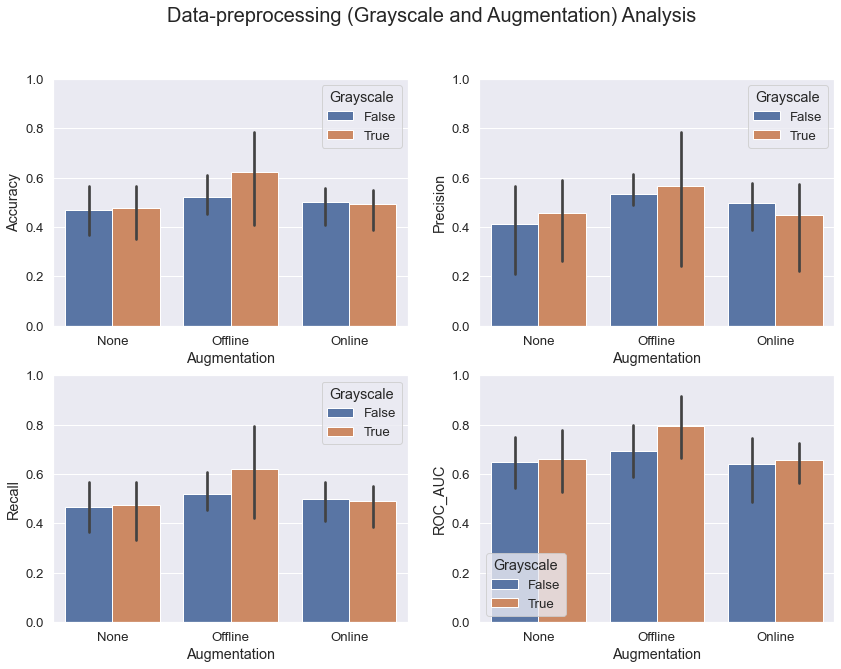

In [289]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
fig.suptitle('Data-preprocessing (Grayscale and Augmentation) Analysis', fontsize=20)

sns.barplot(data=datasets_df, x="Augmentation", y="Accuracy", hue="Grayscale", ax=ax[0,0])
sns.barplot(data=datasets_df, x="Augmentation", y="Precision", hue="Grayscale", ax=ax[0,1])
sns.barplot(data=datasets_df, x="Augmentation", y="Recall", hue="Grayscale", ax=ax[1,0])
sns.barplot(data=datasets_df, x="Augmentation", y="ROC_AUC", hue="Grayscale", ax=ax[1,1])

ax[0,0].set_ylim(0, 1)
ax[0,1].set_ylim(0, 1)
ax[1,0].set_ylim(0, 1)
ax[1,1].set_ylim(0, 1)

fig.savefig('Appendix/augmentation_grayscale_analysis.png')
plt.show()

#### Update dataset option variable to best option

In [216]:
DS_OPT = {"grayscale":True,
          "aug_type":'Offline'}

# 6 Baseline Model

#### Build model

In [314]:
baseline_dataset, baseline_paths, baseline_model, trained_baseline_model = build_train_baseline_model(
                                                                                  model_name='baseline_model',
                                                                                  ds_opt = DS_OPT,
                                                                                  layers=LAYERS, 
                                                                                  output_dimension=OUTPUT_DIMENSION, 
                                                                                  input_dimension=INPUT_DIMENSION, 
                                                                                  learning_rate = LEARNING_RATE,
                                                                                  optimizer=OPTIMIZER, 
                                                                                  loss_func=LOSS_FUNC, 
                                                                                  metrics=METRICS,
                                                                                  batch_size=BATCH_SIZE,
                                                                                  epochs=EPOCHS)

Model hyperparameters:
{'Dataset': 'off_aug_gs_ds/Baseline', 'Augmentation': 'Offline', 'Grayscale': True, 'Dense_Params': '[]', 'Add_Dropout': False, 'Dropout_Rate': 0.5, 'First_Dropout': True, 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}

Model paths:
{'Model_Path': 'models/baseline_model_1693413223.keras', 'History_Path': 'models/trained_baseline_model_1693413223.pkl'}

Model exists: True 



2023-09-21 05:43:10.864169: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c22337074c14499ca5214548b9fa9487: INVALID_ARGUMENT: ram://c22337074c14499ca5214548b9fa9487 is a directory.


2/2 [==============================] - 0s 25ms/step


In [315]:
baseline_model.summary() 

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 flatten_39 (Flatten)        (None, 50176)             0         
                                                                 
 dense_111 (Dense)           (None, 64)                3211328   
                                                                 
 dense_112 (Dense)           (None, 3)                 195       
                                                                 
Total params: 3,211,971
Trainable params: 3,211,971
Non-trainable params: 0
__________________________________________

#### Evaluation on validation set

In [316]:
baseline_val_score = baseline_model.evaluate(baseline_dataset['X_val'], 
                                             baseline_dataset['y_val'])

3/3 [==============================] - 1s 37ms/step - loss: 1.0964 - accuracy: 0.3333 - precision: 0.5000 - recall: 0.0312 - auc: 0.6053  


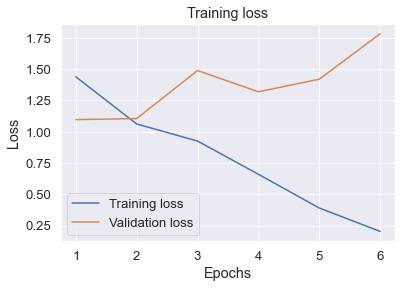

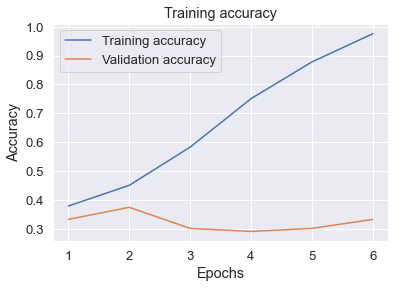

In [458]:
plot_history(trained_baseline_model, 'loss')
plot_history(trained_baseline_model, 'accuracy')

#### Evaluation on test set

2/2 [==============================] - 0s 23ms/step
Score results from predicting the test set:
Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
AUC: 0.6037


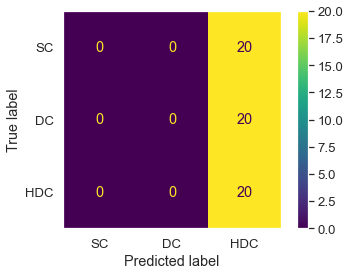

In [318]:
metrics_exist = check_metrics_exist(baseline_paths)
metrics = get_results(baseline_model, 
          baseline_dataset['X_test'], 
          baseline_dataset['y_test'],
          baseline_paths,
          metrics_exist=metrics_exist,
          print_results=True)

# 7 Pre-trained models

## 7.1 Xception model

#### Build and train model

In [319]:
xception_dataset, xception_paths, xception_model, trained_xception_model = build_train_pretrained_model(
                                                                                  model_name='xception_model',
                                                                                  ds_opt = DS_OPT,
                                                                                  dropout_rate = DROPOUT_RATE,
                                                                                  first_dropout = FIRST_DROPOUT,
                                                                                  layers=LAYERS, 
                                                                                  output_dimension=OUTPUT_DIMENSION, 
                                                                                  input_dimension=INPUT_DIMENSION, 
                                                                                  learning_rate = LEARNING_RATE,
                                                                                  optimizer=OPTIMIZER, 
                                                                                  loss_func=LOSS_FUNC, 
                                                                                  metrics=METRICS,
                                                                                  batch_size=BATCH_SIZE,
                                                                                  epochs=EPOCHS)

Model hyperparameters:
{'Dataset': 'off_aug_gs_ds/Xception', 'Augmentation': 'Offline', 'Grayscale': True, 'Dense_Params': '[]', 'Add_Dropout': False, 'Dropout_Rate': 0.5, 'First_Dropout': True, 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}

Model paths:
{'Model_Path': 'models/xception_model_1693413271.keras', 'History_Path': 'models/trained_xception_model_1693413271.pkl'}

Model exists: True 



2023-09-21 05:44:11.576012: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dd14e11d2b6146df8b1410094d985eb2: INVALID_ARGUMENT: ram://dd14e11d2b6146df8b1410094d985eb2 is a directory.


2/2 [==============================] - 5s 2s/step


In [320]:
xception_model.summary()

Model: "xception_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_34[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                    

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_211 (Add)                  (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_210[0][0]']                
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_211[0][0]']                
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_214 (

#### Evaluation on validation set

In [321]:
xception_val_score = xception_model.evaluate(xception_dataset['X_val'], xception_dataset['y_val'])

3/3 [==============================] - 8s 2s/step - loss: 0.7569 - accuracy: 0.6875 - precision: 0.7160 - recall: 0.6042 - auc: 0.8380


#### Loss and accuracy functions

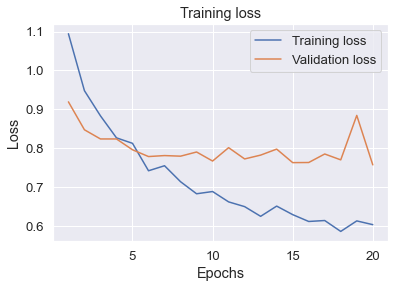

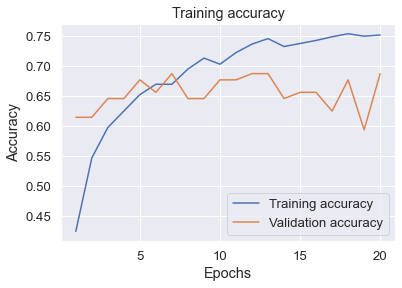

In [459]:
plot_history(trained_xception_model, 'loss')
plot_history(trained_xception_model, 'accuracy')

#### Evaluation on test set

2/2 [==============================] - 4s 2s/step
Score results from predicting the test set:
Accuracy: 0.6333
Precision: 0.6335
Recall: 0.6333
AUC: 0.7979


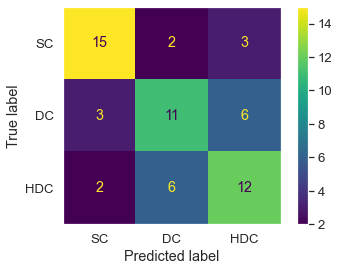

In [340]:
metrics_exist = check_metrics_exist(xception_paths)

metrics = get_results(xception_model, 
          xception_dataset['X_test'], 
          xception_dataset['y_test'],
          xception_paths,
          metrics_exist=metrics_exist,
          print_results=True)

## 7.2 VGG-16 model

#### Build and train model

In [352]:
vgg16_dataset, vgg16_paths, vgg16_model, trained_vgg16_model = build_train_pretrained_model(
                                                                                  model_name='vgg16_model',
                                                                                  ds_opt = DS_OPT,
                                                                                  dropout_rate = DROPOUT_RATE,
                                                                                  first_dropout = FIRST_DROPOUT,
                                                                                  layers=LAYERS, 
                                                                                  output_dimension=OUTPUT_DIMENSION, 
                                                                                  input_dimension=INPUT_DIMENSION, 
                                                                                  learning_rate = LEARNING_RATE,
                                                                                  optimizer=OPTIMIZER, 
                                                                                  loss_func=LOSS_FUNC, 
                                                                                  metrics=METRICS,
                                                                                  batch_size=BATCH_SIZE,
                                                                                  epochs=EPOCHS)

Model hyperparameters:
{'Dataset': 'off_aug_gs_ds/VGG16', 'Augmentation': 'Offline', 'Grayscale': True, 'Dense_Params': '[]', 'Add_Dropout': False, 'Dropout_Rate': 0.5, 'First_Dropout': True, 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}

Model paths:
{'Model_Path': 'models/vgg16_model_1693414657.keras', 'History_Path': 'models/trained_vgg16_model_1693414657.pkl'}

Model exists: True 



2023-09-21 06:04:18.325184: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f5190e6a31b2471fa3b5d0dc001e7bc7: INVALID_ARGUMENT: ram://f5190e6a31b2471fa3b5d0dc001e7bc7 is a directory.


2/2 [==============================] - 11s 5s/step


In [327]:
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

#### Evaluation on validation set

In [328]:
vgg16_val_score = vgg16_model.evaluate(vgg16_dataset['X_val'], vgg16_dataset['y_val'])

3/3 [==============================] - 16s 5s/step - loss: 0.9238 - accuracy: 0.5833 - precision: 0.6119 - recall: 0.4271 - auc: 0.7539


#### Loss and accuracy functions

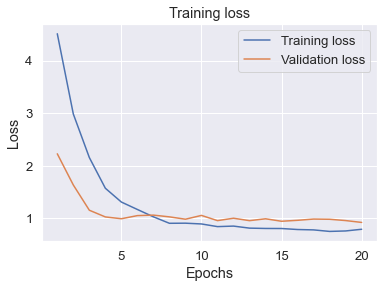

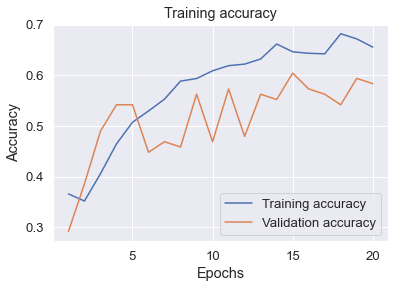

In [460]:
plot_history(trained_vgg16_model, 'loss')
plot_history(trained_vgg16_model, 'accuracy')

#### Evaluation on test set

2/2 [==============================] - 8s 4s/step
Score results from predicting the test set:
Accuracy: 0.6833
Precision: 0.6892
Recall: 0.6833
AUC: 0.8429


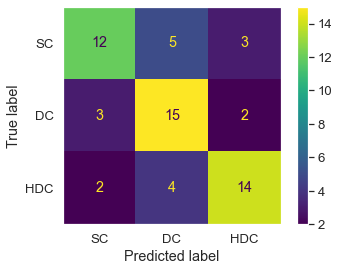

In [341]:
metrics_exist = check_metrics_exist(vgg16_paths)

metrics = get_results(vgg16_model, 
          vgg16_dataset['X_test'], 
          vgg16_dataset['y_test'],
          vgg16_paths,
          metrics_exist=metrics_exist,
          print_results=True)

## 7.3 ResNet-50 model

#### Build and train model

In [351]:
resnet50_dataset, resnet50_paths, resnet50_model, trained_resnet50_model = build_train_pretrained_model(
                                                                                  model_name='resnet50_model',
                                                                                  ds_opt = DS_OPT,
                                                                                  dropout_rate = DROPOUT_RATE,
                                                                                  first_dropout = FIRST_DROPOUT,
                                                                                  layers=LAYERS, 
                                                                                  output_dimension=OUTPUT_DIMENSION, 
                                                                                  input_dimension=INPUT_DIMENSION, 
                                                                                  learning_rate = LEARNING_RATE,
                                                                                  optimizer=OPTIMIZER, 
                                                                                  loss_func=LOSS_FUNC, 
                                                                                  metrics=METRICS,
                                                                                  batch_size=BATCH_SIZE,
                                                                                  epochs=EPOCHS)

Model hyperparameters:
{'Dataset': 'off_aug_gs_ds/ResNet50', 'Augmentation': 'Offline', 'Grayscale': True, 'Dense_Params': '[]', 'Add_Dropout': False, 'Dropout_Rate': 0.5, 'First_Dropout': True, 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}

Model paths:
{'Model_Path': 'models/resnet50_model_1693417628.keras', 'History_Path': 'models/trained_resnet50_model_1693417628.pkl'}

Model exists: True 



2023-09-21 06:04:02.162398: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8068919958ce49e694806a4b309d3f51: INVALID_ARGUMENT: ram://8068919958ce49e694806a4b309d3f51 is a directory.


2/2 [==============================] - 6s 2s/step


In [335]:
resnet50_model.summary()

Model: "resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_36[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

#### Evaluation on validation set

In [336]:
resnet50_val_score = resnet50_model.evaluate(resnet50_dataset['X_val'], resnet50_dataset['y_val'])

3/3 [==============================] - 9s 2s/step - loss: 0.6298 - accuracy: 0.7708 - precision: 0.7826 - recall: 0.7500 - auc: 0.9010


#### Loss and accuracy functions

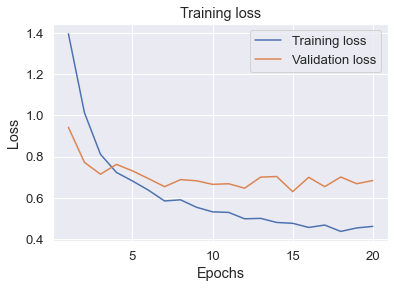

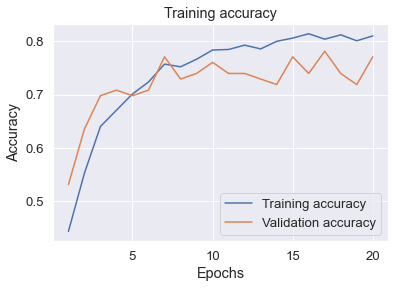

In [461]:
plot_history(trained_resnet50_model, 'loss')
plot_history(trained_resnet50_model, 'accuracy')

#### Evaluation on test set

2/2 [==============================] - 4s 2s/step
Score results from predicting the test set:
Accuracy: 0.8333
Precision: 0.8333
Recall: 0.8333
AUC: 0.9396


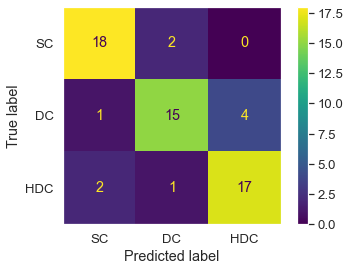

In [342]:
metrics_exist = check_metrics_exist(resnet50_paths)

metrics = get_results(resnet50_model, 
          resnet50_dataset['X_test'], 
          resnet50_dataset['y_test'],
          resnet50_paths,
          metrics_exist=metrics_exist,
          print_results=True)

## 7.4 Analysis

#### Set up dataframe

In [344]:
models_df = datasets_df[(datasets_df['Augmentation']=='Offline') &
                        (datasets_df['Grayscale']==True) &
                        (datasets_df['Model']!='Baseline')]
models_df

,Model,Augmentation,Grayscale,Accuracy,Precision,Recall,ROC_AUC
23,ResNet50,Offline,True,0.833333,0.833333,0.833333,0.939583
22,VGG16,Offline,True,0.683333,0.689241,0.683333,0.842917
21,Xception,Offline,True,0.633333,0.633459,0.633333,0.797917


#### Plot data

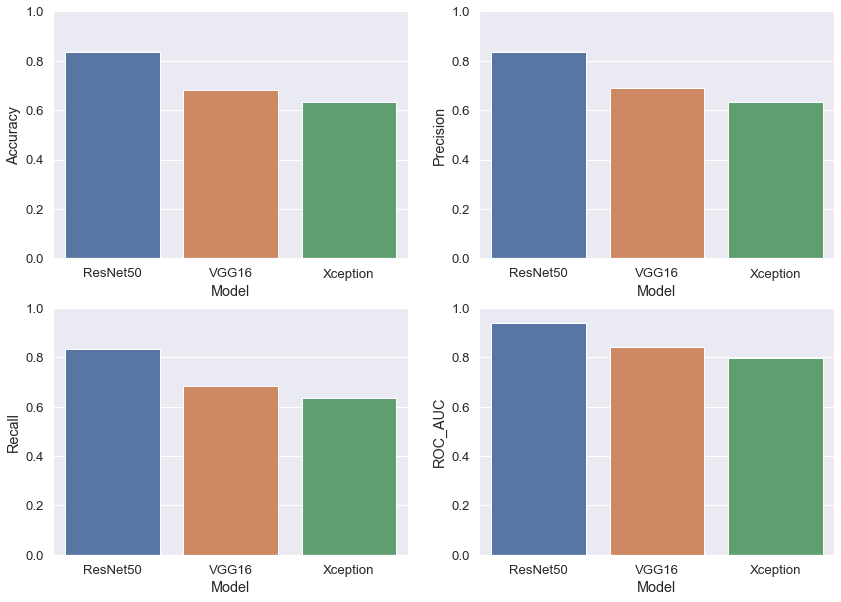

In [346]:
fig, ax = plt.subplots(2,2, figsize=(14,10))

sns.barplot(data=models_df, x="Model", y="Accuracy", ax=ax[0,0])
sns.barplot(data=models_df, x="Model", y="Precision", ax=ax[0,1])
sns.barplot(data=models_df, x="Model", y="Recall", ax=ax[1,0])
sns.barplot(data=models_df, x="Model", y="ROC_AUC", ax=ax[1,1])

ax[0,0].set_ylim(0, 1)
ax[0,1].set_ylim(0, 1)
ax[1,0].set_ylim(0, 1)
ax[1,1].set_ylim(0, 1)

fig.savefig('Appendix/models_analysis.png')
plt.show()

#### Set best pre-trained model to a variable

In [353]:
MODEL_NAME = 'resnet50_model'

# 8 Hyperparameter tuning

In [410]:
# Get all data except for testing set
best_ds, _ = choose_dataset(MODEL_NAME, True, 'Offline', batch_size=BATCH_SIZE)

## 8.1 Implement grid search

In [50]:
# Adapted from https://www.geeksforgeeks.org/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/

In [439]:
param_grid = {
    "model_name" : [MODEL_NAME],
#     "optimizer" : [OPTIMIZER],
    "learning_rate" : [0.01, 0.001, 0.0001],
    "dropout_rate" : [0.2, 0.5],
    "first_dropout" : [True],
    "layers" : [
        # One layer (basic)
        {"dense_params": [32],
         "add_dropout": [True]},
        # Wide (large neurons)
        {"dense_params": [64],
         "add_dropout": [True]},
        # Deep
        {"dense_params": [32, 32],
         "add_dropout": [True, True]},
        # Wide and deep
        {"dense_params": [64, 32],
         "add_dropout": [True, True]}
    ],
  
    "batch_size" : [16, 32],
    "epochs" : [20, 40]
}

In [440]:
model = KerasClassifier(build_fn=build_pretrained_model, 
                        dropout_rate=None, 
                        layers=None, 
                        first_dropout=None, 
                        model_name=None, 
                        learning_rate=None)

In [441]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10, n_jobs=-1)

In [443]:
# Comment out this entire section when grid search is done

# Run grid search
# grid_result = grid.fit(best_ds['X_train'], best_ds['y_train'])

# Export grid search results as a csv file
# gridsearch_df = pd.DataFrame.from_dict(grid_result.cv_results_)
# gridsearch_df.to_csv('grid_search_results.csv', index=False)

## 8.2 Results

In [370]:
gridsearch_df = pd.read_csv('grid_search_results.csv')
gridsearch_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_dropout_rate,param_epochs,param_first_dropout,param_layers,param_learning_rate,param_model_name,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2601.324015,14.322134,60.430482,34.427069,16,0.2,20,True,"{'dense_params': [32], 'add_dropout': [True]}",0.0100,resnet50_model,"{'batch_size': 16, 'dropout_rate': 0.2, 'epoch...",0.801829,0.731707,0.786585,0.773374,0.030113,31
1,2611.441246,0.138711,84.704041,0.300634,16,0.2,20,True,"{'dense_params': [32], 'add_dropout': [True]}",0.0010,resnet50_model,"{'batch_size': 16, 'dropout_rate': 0.2, 'epoch...",0.835366,0.801829,0.820122,0.819106,0.013710,10
2,2611.335789,0.081731,85.430114,0.804773,16,0.2,20,True,"{'dense_params': [32], 'add_dropout': [True]}",0.0001,resnet50_model,"{'batch_size': 16, 'dropout_rate': 0.2, 'epoch...",0.774390,0.707317,0.740854,0.740854,0.027383,41
3,2611.796623,0.366084,79.617628,9.686367,16,0.2,20,True,"{'dense_params': [64], 'add_dropout': [True]}",0.0100,resnet50_model,"{'batch_size': 16, 'dropout_rate': 0.2, 'epoch...",0.783537,0.780488,0.774390,0.779472,0.003802,29
4,2601.080550,15.660622,63.312264,35.115597,16,0.2,20,True,"{'dense_params': [64], 'add_dropout': [True]}",0.0010,resnet50_model,"{'batch_size': 16, 'dropout_rate': 0.2, 'epoch...",0.859756,0.817073,0.774390,0.817073,0.034850,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,5193.266378,31.845366,91.824984,0.995016,32,0.5,40,True,"{'dense_params': [32, 32], 'add_dropout': [Tru...",0.0010,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.682927,0.673780,0.670732,0.675813,0.005182,56
92,4621.744175,24.775724,65.509285,18.007913,32,0.5,40,True,"{'dense_params': [32, 32], 'add_dropout': [Tru...",0.0001,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.506098,0.371951,0.362805,0.413618,0.065500,90
93,4561.972010,20.729713,46.121218,0.491575,32,0.5,40,True,"{'dense_params': [64, 32], 'add_dropout': [Tru...",0.0100,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.673780,0.594512,0.704268,0.657520,0.046259,60
94,3867.240869,895.821343,19.693088,5.323625,32,0.5,40,True,"{'dense_params': [64, 32], 'add_dropout': [Tru...",0.0010,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.719512,0.719512,0.743902,0.727642,0.011498,45


In [371]:
best_params_df = gridsearch_df.loc[gridsearch_df['rank_test_score'] == 1]
best_params_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_dropout_rate,param_epochs,param_first_dropout,param_layers,param_learning_rate,param_model_name,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
64,5350.553406,16.669782,78.427186,11.260863,32,0.2,40,True,"{'dense_params': [64], 'add_dropout': [True]}",0.001,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.856707,0.838415,0.853659,0.849593,0.008002,1


In [404]:
best_params = eval(best_params_df['params'].values[0])
print('The best hyperparameters obtained from the grid search:')
best_params

The best hyperparameters obtained from the grid search:


{'batch_size': 32,
 'dropout_rate': 0.2,
 'epochs': 40,
 'first_dropout': True,
 'layers': {'dense_params': [64], 'add_dropout': [True]},
 'learning_rate': 0.001,
 'model_name': 'resnet50_model'}

In [444]:
worst_params_df = gridsearch_df.loc[gridsearch_df['rank_test_score'] == 96]
worst_params_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_dropout_rate,param_epochs,param_first_dropout,param_layers,param_learning_rate,param_model_name,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
80,2716.035298,3.891725,83.784908,14.622522,32,0.5,20,True,"{'dense_params': [32, 32], 'add_dropout': [Tru...",0.0001,resnet50_model,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.356707,0.314024,0.304878,0.325203,0.022588,96


In [445]:
worst_params = eval(worst_params_df['params'].values[0])
print('The worst hyperparameters obtained from the grid search:')
worst_params

The worst hyperparameters obtained from the grid search:


{'batch_size': 32,
 'dropout_rate': 0.5,
 'epochs': 20,
 'first_dropout': True,
 'layers': {'dense_params': [32, 32], 'add_dropout': [True, True]},
 'learning_rate': 0.0001,
 'model_name': 'resnet50_model'}

## 8.3 Best model obtained from grid search

In [395]:
best_model_path = 'models/best_model.keras'
trained_best_model_path = 'models/trained_best_model.pkl'

#### Build and train model

In [383]:
best_model = build_pretrained_model(model_name=MODEL_NAME,
                        dropout_rate = best_params['dropout_rate'],
                        first_dropout = best_params['first_dropout'],
                        layers = best_params['layers'],
                        output_dimension=OUTPUT_DIMENSION, 
                        input_dimension=INPUT_DIMENSION, 
                        learning_rate=best_params['learning_rate'],
                        loss_func=LOSS_FUNC, 
                        metrics=METRICS)

In [384]:
best_model.summary()

Model: "resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [385]:
if not os.path.exists(best_model_path):
    trained_best_model = best_model.fit(best_ds['X_train'], best_ds['y_train'],
                                        batch_size=best_params['batch_size'], 
                                        epochs=best_params['epochs'], 
                                        validation_data=(resnet50_ds['X_val'], resnet50_ds['y_val']),
                                        callbacks=[EARLY_STOP],
                                        verbose=1)

Epoch 1/40
31/31 [==============================] - 92s 3s/step - loss: 1.2703 - accuracy: 0.4245 - precision: 0.4454 - recall: 0.3372 - auc: 0.5951 - val_loss: 0.9298 - val_accuracy: 0.5938 - val_precision: 0.7561 - val_recall: 0.3229 - val_auc: 0.7727
Epoch 2/40
31/31 [==============================] - 85s 3s/step - loss: 0.8257 - accuracy: 0.6169 - precision: 0.6988 - recall: 0.4787 - auc: 0.8081 - val_loss: 0.7220 - val_accuracy: 0.6979 - val_precision: 0.7500 - val_recall: 0.5938 - val_auc: 0.8578
Epoch 3/40
31/31 [==============================] - 108s 4s/step - loss: 0.6747 - accuracy: 0.7104 - precision: 0.7687 - recall: 0.6280 - auc: 0.8743 - val_loss: 0.7006 - val_accuracy: 0.7188 - val_precision: 0.7640 - val_recall: 0.7083 - val_auc: 0.8739
Epoch 4/40
31/31 [==============================] - 93s 3s/step - loss: 0.5909 - accuracy: 0.7429 - precision: 0.7881 - recall: 0.6992 - auc: 0.9038 - val_loss: 0.6664 - val_accuracy: 0.7083 - val_precision: 0.7500 - val_recall: 0.6875 -

#### Save model in local disk

In [420]:
if os.path.exists(best_model_path):
    # Load model
    best_model = load_model(best_model_path)
    # Load model history
    trained_best_model = load(open(trained_best_model_path, 'rb'))
else:
    # Save model locally
    save_model(best_model, best_model_path)
    # Save model history
    dump(trained_best_model, open(trained_best_model_path, 'wb'))

2023-09-21 17:29:48.335178: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5888fbbcbbec45459349524f2fbfe0ce: INVALID_ARGUMENT: ram://5888fbbcbbec45459349524f2fbfe0ce is a directory.


#### Evaluation on validation set

In [421]:
best_model_val_score = best_model.evaluate(best_ds['X_val'], best_ds['y_val'])

3/3 [==============================] - 10s 3s/step - loss: 0.6664 - accuracy: 0.7083 - precision: 0.7500 - recall: 0.6875 - auc: 0.8873


#### Loss and accuracy functions

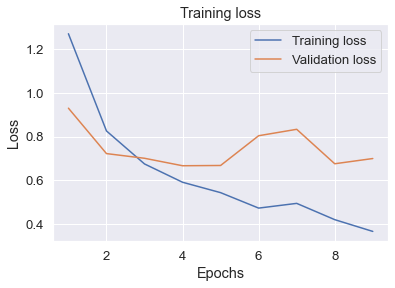

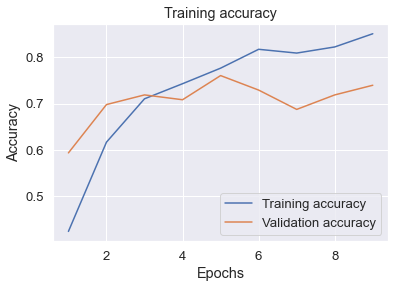

In [462]:
plot_history(trained_best_model, 'loss')
plot_history(trained_best_model, 'accuracy')

#### Evaluation on test set

2/2 [==============================] - 7s 3s/step
Score results from predicting the test set:
Accuracy: 0.7167
Precision: 0.7345
Recall: 0.7167
AUC: 0.9108


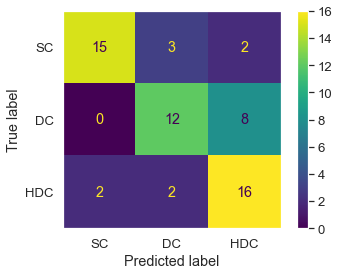

In [401]:
metrics = get_results(best_model, 
          best_ds['X_test'], 
          best_ds['y_test'],
          print_results=True)

# 9 Final model

## 9.1 Prepare train set

In [411]:
# Get all data except for testing set
X_train_val, y_train_val = (np.concatenate([best_ds['X_train'],
                                           best_ds['X_val']]), 
                            np.concatenate([best_ds['y_train'], 
                                            best_ds['y_val']]))
# Shuffle data
rand_i = np.arange(len(X_train_val))
np.random.seed(0) 
np.random.shuffle(rand_i)
X_train_val, y_train_val = X_train_val[rand_i], y_train_val[rand_i]

print('X_train_val shape:', X_train_val.shape)
print('y_train_val shape:', y_train_val.shape)

X_train_val shape: (1080, 224, 224, 3)
y_train_val shape: (1080, 3)


## 9.2 Implement final model

In [430]:
print('Hyperparameters for final model\n-------------------------------')
# best_params
print('model_name:', MODEL_NAME)
print('dropout_rate:', best_params['dropout_rate'])
print('first_dropout:', best_params['first_dropout'])
print('layers:', best_params['layers'])
print('output_dimension:', OUTPUT_DIMENSION) 
print('input_dimension:', INPUT_DIMENSION) 
print('learning_rate:', best_params['learning_rate'])
print('loss_func:', LOSS_FUNC)
print('metrics:', METRICS)

Hyperparameters for final model
-------------------------------
model_name: resnet50_model
dropout_rate: 0.2
first_dropout: True
layers: {'dense_params': [64], 'add_dropout': [True]}
output_dimension: 3
input_dimension: (224, 224, 3)
learning_rate: 0.001
loss_func: categorical_crossentropy
metrics: [<keras.metrics.accuracy_metrics.CategoricalAccuracy object at 0x7fb3ffddfdf0>, <keras.metrics.confusion_metrics.Precision object at 0x7fb3f70634f0>, <keras.metrics.confusion_metrics.Recall object at 0x7fb3f709a340>, <keras.metrics.confusion_metrics.AUC object at 0x7fb32bf51400>]


In [416]:
final_model_path = 'models/final_model.keras'
trained_final_model_path = 'models/trained_final_model.pkl'

#### Build and train model

In [431]:
final_model = build_pretrained_model(model_name=MODEL_NAME,
                        dropout_rate = best_params['dropout_rate'],
                        first_dropout = best_params['first_dropout'],
                        layers = best_params['layers'],
                        output_dimension=OUTPUT_DIMENSION, 
                        input_dimension=INPUT_DIMENSION, 
                        learning_rate=best_params['learning_rate'],
                        loss_func=LOSS_FUNC, 
                        metrics=METRICS)

In [432]:
final_model.summary()

Model: "resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [433]:
if not os.path.exists(final_model_path):
    trained_final_model = final_model.fit(X_train_val, y_train_val,
                                          batch_size=best_params['batch_size'], 
                                          epochs=best_params['epochs'], 
                                          validation_data=(best_ds['X_val'], best_ds['y_val']),
                                          callbacks=[EARLY_STOP],
                                          verbose=1)

#### Save model to local disk

In [434]:
if os.path.exists(final_model_path):
    # Load model
    final_model = load_model(final_model_path)
    # Load model history
    trained_final_model = load(open(trained_final_model_path, 'rb'))
else:
    # Save model locally
    save_model(final_model, final_model_path)
    # Save model history
    dump(trained_final_model, open(trained_final_model_path, 'wb'))

2023-09-21 17:34:12.569130: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0d9fdd9296414f92af2ea786cedbf152: INVALID_ARGUMENT: ram://0d9fdd9296414f92af2ea786cedbf152 is a directory.


#### Loss and accuracy functions

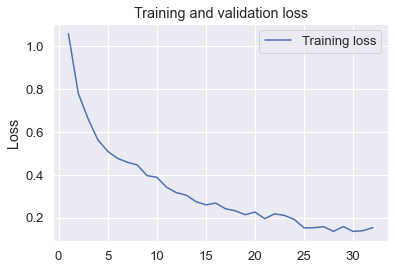

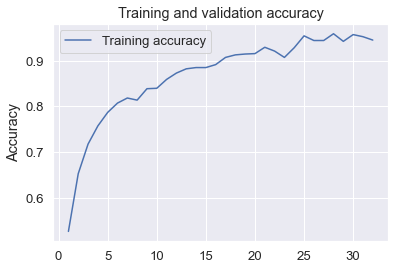

In [456]:
plot_history(trained_final_model, 'loss', val_data=False)
plot_history(trained_final_model, 'accuracy', val_data=False)

#### Evaluation on test set

2/2 [==============================] - 7s 3s/step
Score results from predicting the test set:
Accuracy: 0.8667
Precision: 0.8739
Recall: 0.8667
AUC: 0.9437


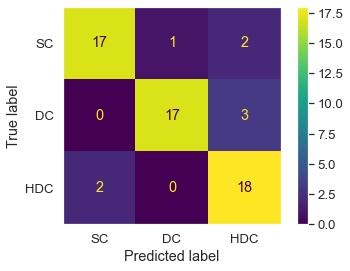

In [436]:
metrics = get_results(final_model, 
          gridsearch_ds['X_test'], 
          gridsearch_ds['y_test'],
          print_results=True)

# 10 Model deployment

In [463]:
# https://github.com/nachi-hebbar/Flower-Classification-Web-App-Streamlit/blob/main/Flower_Classification_WebApp%20(1).ipynb

In [464]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
import streamlit as st
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('models/final_model.keras')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()

st.write("""
         # Crochet Stitches Classification
         """
         )

file = st.file_uploader("Please upload an image of the crochet stitch", type=["jpg", "png", "jpeg"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
    size = (224,224)    
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    image = np.asarray(image)
    
    # Convert images to grayscale
    image = rgb2gray(np.copy(image))

    # Reshape image from grayscale colorspace to rgb colorspace
    image = np.expand_dims(image, axis=3)
    image = image.repeat(3, axis=-1)
    
    # Data normalization
    img = resnet50_preprocess(image)

    img_reshape = img[np.newaxis,...]

    prediction = model.predict(img_reshape)

    return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(predictions)
    st.write(score)
    class_names = ['Single Crochet', 'Double Crochet', 'Half Double Crochet']
    res = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100*np.max(score))
    st.text(res)

Overwriting app.py


In [ ]:
!ngrok authtoken 2SNsBb4SSo5MgswBLoV9ZgMrlO8_vqkCU2i1uogXU7DU9zSS

In [ ]:
!nohup streamlit run app.py